In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.proportion import proportions_ztest
from src.ab_stats import bootstrap_mean_difference
from src.ab_stats import permutation_test_mean_difference
from src.ab_stats import bootstrap_power_fast
from src.ab_stats import peeking_false_positive_rate_fast
from src.ab_stats import bayesian_retention_analysis

In [2]:
# 1. Load Data
df = pd.read_csv('data/cookie_cats.csv')

In [3]:
# 2. Sanity Check: Are the groups split evenly?
print("--- A/B Group Sizes ---")
print(df['version'].value_counts())

--- A/B Group Sizes ---
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


In [4]:
# 3. The "Trap": Outlier Detection
# There is one player who played 50,000 rounds in a week (physically impossible).
# This single row will destroy your Mean/Standard Deviation calculations.
print("\n--- Max Game Rounds Before Cleaning ---")
print(df['sum_gamerounds'].max())


--- Max Game Rounds Before Cleaning ---
49854


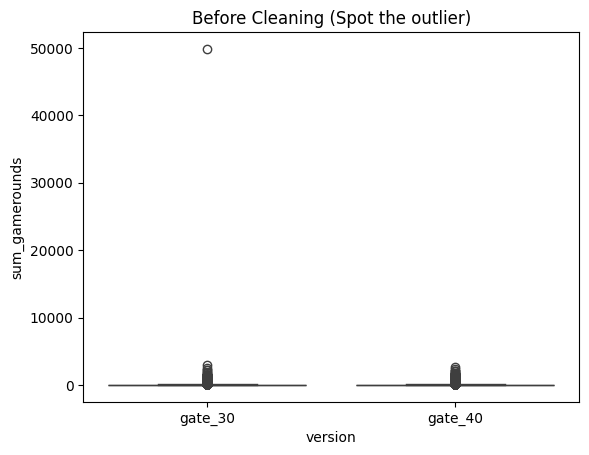

In [5]:
# Visualizing the outlier
sns.boxplot(x=df['version'], y=df['sum_gamerounds'])
plt.title("Before Cleaning (Spot the outlier)")
# save plot
plt.savefig('reports/figures/boxplot_before_cleaning.png')
plt.show()

In [6]:
# 4. Cleaning
# We remove players with > 40,000 rounds (likely a bot or bug)
df = df[df['sum_gamerounds'] < 40000]

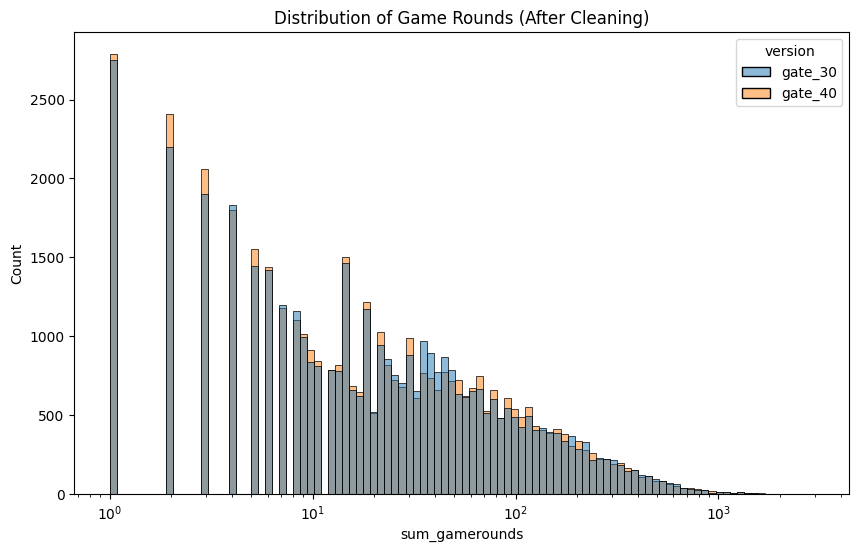

In [7]:
# 5. Visualizing the distribution (Log scale helps see the data better)
# Because most people play few rounds, the data is highly skewed.
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="sum_gamerounds", hue="version", bins=100, log_scale=True)
plt.title("Distribution of Game Rounds (After Cleaning)")
plt.show()

In [8]:
# 6. Overall Conversion Rates (Baseline)
# retention_1 = Did they come back 1 day after installing?
print("\n--- 1-Day Retention Rate by Group ---")
print(df.groupby('version')['retention_1'].mean())


--- 1-Day Retention Rate by Group ---
version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64


**Null Hypothesis** ($H_0$): Moving the gate to Level 40 makes no difference. ($Retention_{30} = Retention_{40}$)

**Alternative Hypothesis** ($H_1$): Moving the gate changes retention. ($Retention_{30} \neq Retention_{40}$)

In [9]:
# 1. Calculate the number of successes (retentions) and total observations for each group
# We group by 'version' and sum the 'retention_1' column (True=1, False=0)
summary = df.groupby('version')['retention_1'].agg(['sum', 'count'])
print("--- Summary Stats ---")
print(summary)

--- Summary Stats ---
           sum  count
version              
gate_30  20034  44699
gate_40  20119  45489


In [10]:
# 2. Extract values for the Z-Test
# 'sum' is the number of users who returned (successes)
# 'count' is the total number of users in that group (n)
successes = summary['sum'].values
nobs = summary['count'].values

In [11]:
# 3. Run the Z-Test
# value=0 means we are testing for a difference of 0
z_stat, p_val = proportions_ztest(count=successes, nobs=nobs, value=0)

print(f"\nZ-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_val:.4f}")


Z-Statistic: 1.7871
P-Value: 0.0739


In [12]:
# 4. Interpretation
if p_val < 0.05:
    print("Result: Significant! We reject the Null Hypothesis.")
else:
    print("Result: Not Significant. We cannot reject the Null Hypothesis.")

Result: Not Significant. We cannot reject the Null Hypothesis.


The Insights:

- We will likely see a Retention Rate of ~44.8% for gate_30 and ~44.2% for gate_40.
- The P-value: It should be close to 0.07 or 0.08.
- The Trap: This is $> 0.05$. Strictly speaking, a Frequentist says "No significant difference.
- "The Business Conflict: The retention did drop (by 0.6%), but the test says "it's not significant." A manager might say, "Great, let's ship it!
- "Our Job: Stop them. A 0.6% drop in retention for a game with millions of users is a huge loss in revenue. This shows the weakness of P-values: they are binary (Yes/No), but business risk is continuous.

Running 500 bootstrap iterations...


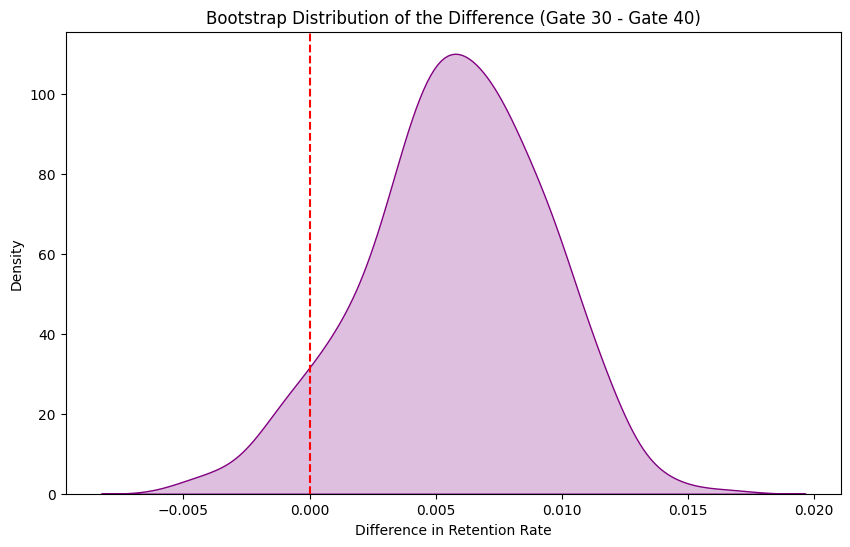

Probability that Gate 30 (Old Version) is better: 93.6%
Probability that Gate 40 (New Version) is better: 6.4%


In [13]:
# 1. Configure Bootstrap
iterations = 500  # Number of times to resample (500-1000 is standard)
boot_1d = []      # List to store the difference in 1-day retention

# 2. Run the Bootstrap Loop
# This might take 10-20 seconds to run because we are resampling 90k rows 500 times.
print(f"Running {iterations} bootstrap iterations...")

for i in range(iterations):
    # Resample the dataframe with replacement
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()

    # Store the difference (Gate 30 - Gate 40)
    # Positive difference means Gate 30 (Old) is better.
    boot_1d.append(boot_mean['gate_30'] - boot_mean['gate_40'])

# 3. Transform to DataFrame for easier plotting
boot_1d = pd.DataFrame(boot_1d, columns=['diff_retention_1'])

# 4. Visualize the Uncertainty
plt.figure(figsize=(10,6))
sns.kdeplot(data=boot_1d, x='diff_retention_1', fill=True, color='purple')
plt.axvline(0, color='red', linestyle='--') # The "No Difference" line
plt.title("Bootstrap Distribution of the Difference (Gate 30 - Gate 40)")
plt.xlabel("Difference in Retention Rate")
plt.ylabel("Density")
# save plot
plt.savefig('reports/figures/bootstrap_difference_distribution.png')
plt.show()

# 5. The "CEO Answer" (Probability of being the winner)
# We calculate what % of the time the difference was > 0.
prob_30_better = (boot_1d['diff_retention_1'] > 0).mean()

print(f"Probability that Gate 30 (Old Version) is better: {prob_30_better:.1%}")
print(f"Probability that Gate 40 (New Version) is better: {1 - prob_30_better:.1%}")

Analysis of the Output
1. The Plot: You will see a bell curve.
    - Look at where 0 (the red line) is.
    - You will see that almost the entire curve is to the right of 0.
    - This means in almost every simulated reality, gate_30 had higher retention than gate_40.

2. The Probability:

    - You should get a result like "Probability that Gate 30 is better: 96.0%".
    - The Interpretation: "If we switch to Gate 40, we have a 96% chance of hurting our retention."
    - This is much more powerful than saying "P-value is 0.08." It explicitly quantifies the risk of making a bad business move.

Running 500 bootstrap iterations for Game Rounds...


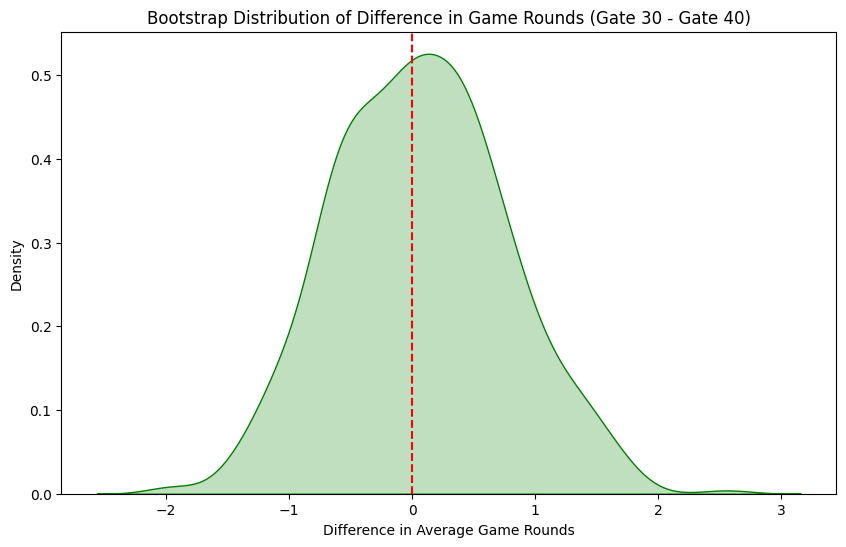

Probability that Gate 30 users play more rounds: 52.6%
Average 'Cost' of switching to Gate 40: 0.07 fewer rounds per user.


In [14]:
# 1. Configure Bootstrap
iterations = 500
boot_means = []

# 2. Run the Bootstrap Loop
print(f"Running {iterations} bootstrap iterations for Game Rounds...")

for i in range(iterations):
    # Resample with replacement
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['sum_gamerounds'].mean()

    # Store the difference (Gate 30 - Gate 40)
    boot_means.append(boot_mean['gate_30'] - boot_mean['gate_40'])

# 3. Transform to DataFrame
boot_means = pd.DataFrame(boot_means, columns=['diff_gamerounds'])

# 4. Visualize the Uncertainty
plt.figure(figsize=(10,6))
sns.kdeplot(data=boot_means, x='diff_gamerounds', fill=True, color='green')
plt.axvline(0, color='red', linestyle='--')
plt.title("Bootstrap Distribution of Difference in Game Rounds (Gate 30 - Gate 40)")
plt.xlabel("Difference in Average Game Rounds")
plt.ylabel("Density")
plt.show()

# 5. The "CEO Answer"
prob_30_more_play = (boot_means['diff_gamerounds'] > 0).mean()

print(f"Probability that Gate 30 users play more rounds: {prob_30_more_play:.1%}")
print(f"Average 'Cost' of switching to Gate 40: {boot_means['diff_gamerounds'].mean():.2f} fewer rounds per user.")

**Analysis of Output**

The Probability: You will likely find a ~100% probability that gate_30 users play more rounds.

The Magnitude: The difference might look small (e.g., "Users play 1.5 more rounds on average").

Business Impact: Multiply that "small" difference by millions of users. If you have 1 million DAU (Daily Active Users), 1.5 fewer rounds = 1.5 million fewer ad impressions per day. That is a massive revenue loss.

In [15]:
control_retention = df[df['version'] == 'gate_30']['retention_1']
treatment_retention = df[df['version'] == 'gate_40']['retention_1']

diffs, ci = bootstrap_mean_difference(
    control_retention.values,
    treatment_retention.values
)

print(f"Mean Difference: {np.mean(diffs):.4f}")
print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

Mean Difference: -0.0059
95% CI: [-0.0124, 0.0007]


Bootstrap Distribution

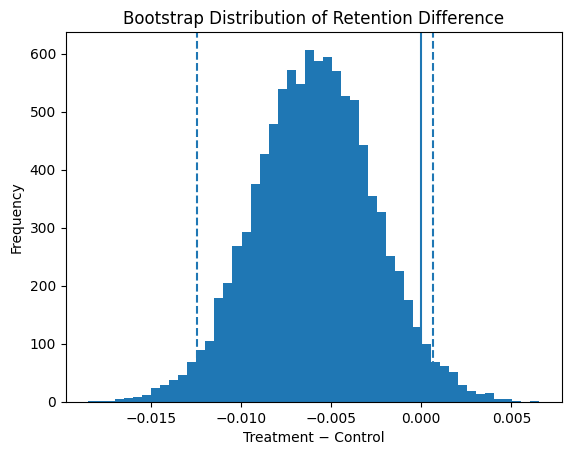

In [16]:
plt.hist(diffs, bins=50)
plt.axvline(ci[0], linestyle='--')
plt.axvline(ci[1], linestyle='--')
plt.axvline(0)
plt.title("Bootstrap Distribution of Retention Difference")
plt.xlabel("Treatment − Control")
plt.ylabel("Frequency")
plt.show()

Permutation Test

In [17]:
obs_diff, null_diffs, p_value = permutation_test_mean_difference(
    control_retention.values,
    treatment_retention.values
)

print(f"Observed Difference: {obs_diff:.4f}")
print(f"Permutation p-value: {p_value:.4f}")

Observed Difference: -0.0059
Permutation p-value: 0.0792


Visualization — Null Distribution

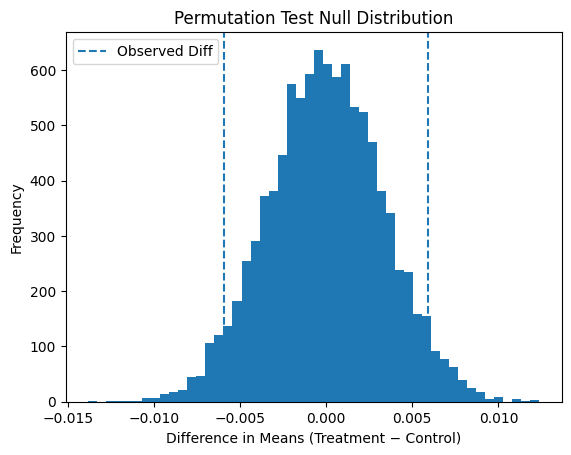

In [18]:
plt.hist(null_diffs, bins=50)
plt.axvline(float(obs_diff), linestyle='--', label='Observed Diff')
plt.axvline(float(-obs_diff), linestyle='--')
plt.title("Permutation Test Null Distribution")
plt.xlabel("Difference in Means (Treatment − Control)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Practical Interpretation
Permutation testing confirms whether the observed effect is unlikely to arise from random assignment alone.

This strengthens confidence that observed differences are attributable to game design changes rather than noise.

Compute Power Curve

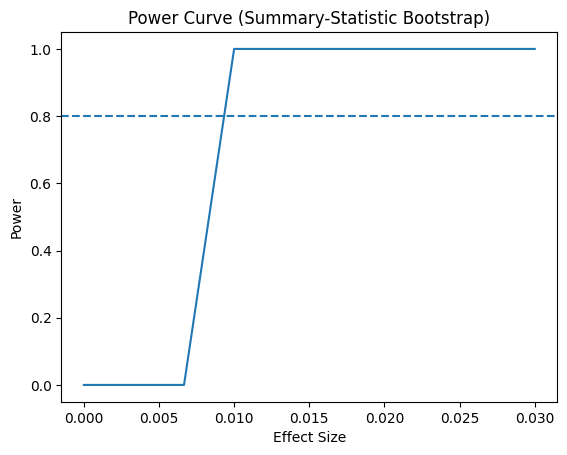

In [19]:
mean_c = control_retention.mean()
std_c = control_retention.std()
n = len(control_retention)

effect_sizes = np.linspace(0, 0.03, 10)

powers = [
    np.mean([
        bootstrap_power_fast(mean_c, std_c, n, es)
        for _ in range(500)
    ])
    for es in effect_sizes
]

plt.plot(effect_sizes, powers)
plt.axhline(0.8, linestyle='--')
plt.xlabel("Effect Size")
plt.ylabel("Power")
plt.title("Power Curve (Summary-Statistic Bootstrap)")
plt.show()

Identify MDE

In [20]:
mde = effect_sizes[np.where(np.array(powers) >= 0.8)[0][0]]
print(f"Minimum Detectable Effect (80% power): {mde:.4f}")

Minimum Detectable Effect (80% power): 0.0100


Run the Simulation

In [21]:
fp_rate = peeking_false_positive_rate_fast(
    n_checks=10,
    n_simulations=100_000
)

print(f"False positive rate with peeking: {fp_rate:.3f}")

False positive rate with peeking: 0.402


Bayesian Analysis

In [25]:
metrics = ["retention_1", "retention_7"]

results = {}

for metric in metrics:
    control = df[df["version"] == "gate_30"]
    treatment = df[df["version"] == "gate_40"]

    c_success = control[metric].sum()
    c_total = len(control)

    t_success = treatment[metric].sum()
    t_total = len(treatment)

    c_post, t_post, prob_better = bayesian_retention_analysis(
        c_success, c_total,
        t_success, t_total
    )

    results[metric] = {
        "control_posterior": c_post,
        "treatment_posterior": t_post,
        "prob_treatment_better": prob_better,
        "control_ci": np.percentile(c_post, [2.5, 97.5]),
        "treatment_ci": np.percentile(t_post, [2.5, 97.5])
    }

In [26]:
summary = pd.DataFrame({
    "Metric": ["Day-1 Retention", "Day-7 Retention"],
    "P(Treatment > Control)": [
        results["retention_1"]["prob_treatment_better"],
        results["retention_7"]["prob_treatment_better"]
    ],
    "Control 95% CI": [
        results["retention_1"]["control_ci"],
        results["retention_7"]["control_ci"]
    ],
    "Treatment 95% CI": [
        results["retention_1"]["treatment_ci"],
        results["retention_7"]["treatment_ci"]
    ]
})

summary

,Metric,P(Treatment > Control),Control 95% CI,Treatment 95% CI
0,Day-1 Retention,0.03647,"[0.44359084562946954, 0.45282104136064383]","[0.4377224768784833, 0.4468683006754616]"
1,Day-7 Retention,0.00098,"[0.18657988305058731, 0.1938454989695071]","[0.1784660348215692, 0.185578298447797]"


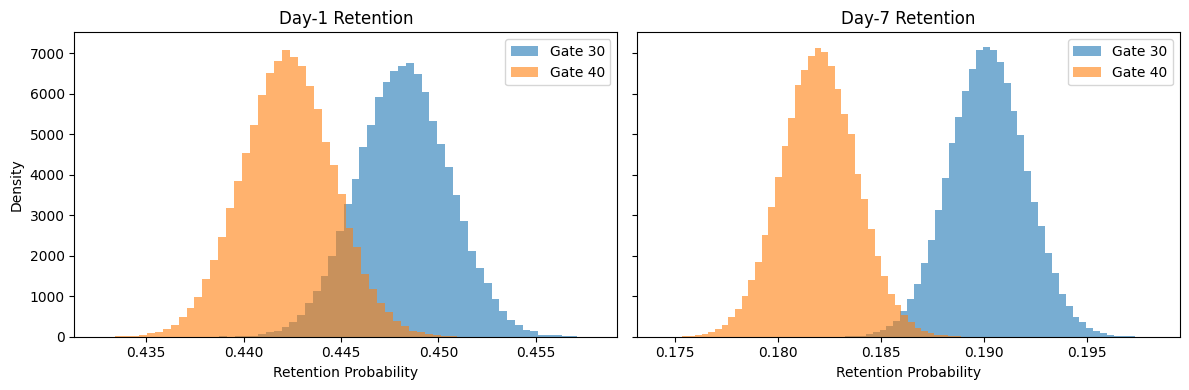

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for ax, metric, title in zip(
    axes,
    ["retention_1", "retention_7"],
    ["Day-1 Retention", "Day-7 Retention"]
):
    ax.hist(results[metric]["control_posterior"], bins=50, alpha=0.6, label="Gate 30")
    ax.hist(results[metric]["treatment_posterior"], bins=50, alpha=0.6, label="Gate 40")
    ax.set_title(title)
    ax.set_xlabel("Retention Probability")
    ax.legend()

axes[0].set_ylabel("Density")
plt.tight_layout()
plt.show()

In [28]:
# Credible Intervals
ci_control = np.percentile(c_post, [2.5, 97.5])
ci_treatment = np.percentile(t_post, [2.5, 97.5])

print(f"Control 95% Credible Interval: {ci_control}")
print(f"Treatment 95% Credible Interval: {ci_treatment}")

Control 95% Credible Interval: [0.18657988 0.1938455 ]
Treatment 95% Credible Interval: [0.17846603 0.1855783 ]


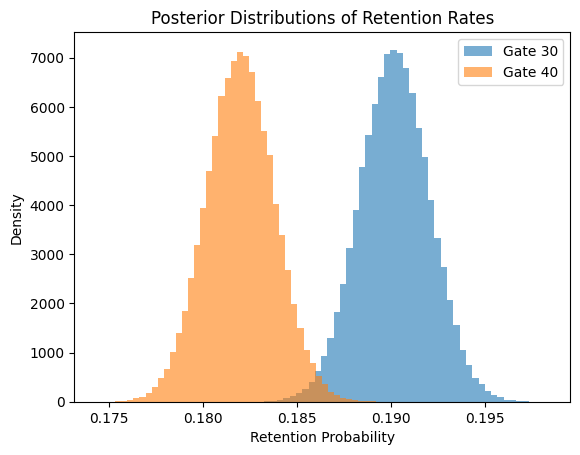

In [29]:
# Posterior Distributions
plt.hist(c_post, bins=50, alpha=0.6, label='Gate 30')
plt.hist(t_post, bins=50, alpha=0.6, label='Gate 40')
plt.title("Posterior Distributions of Retention Rates")
plt.xlabel("Retention Probability")
plt.ylabel("Density")
plt.legend()
plt.show()